I wanted to see how noisy the raw spikes actually are, by comparing with "identity trick" spikes

In [66]:
%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(2, 2, 1)


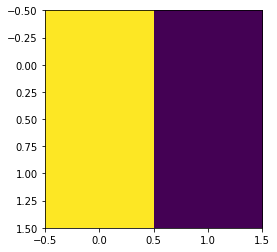

In [67]:
np.random.seed(1)

Y = 4
X = 4
N = X * Y
D = 1
SYN_SPACE = 1
FMAX = 1000 # should determine from syn_tau
BIAS = -2
RUN_TIME = 1 # second

SY = Y // 2 // SYN_SPACE
SX = X // 2 // SYN_SPACE

# taps (or dims) don't really matter for this, but whatever
yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=np.array([[False] * SY] * SX, dtype=bool))
print(yx_taps.shape)

if D == 1:
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])
        
tap_matrix = NetBuilder.syn_taps_to_nrn_taps(yx_taps, spacing=SYN_SPACE)
NetBuilder.make_taps_even(tap_matrix)

In [68]:
# collect raw spikes
from pystorm.hal import HAL, RunControl
HAL = HAL()

net_builder = NetBuilder(HAL)

net = net_builder.create_single_pool_net(Y, X, tap_matrix, biases=BIAS)
pool = net.get_pools()[0]
inp = net.get_inputs()[0]

run = RunControl(HAL, net)

# map the network
HAL.map(net)

times = np.array([0, 1]) * 1e9
zero_rates = np.zeros((len(times), pool.dimensions))                                              
input_vals = {inp: (times, zero_rates)}
_, spikes_and_bin_times = run.run_input_sweep(input_vals, get_raw_spikes=True, get_outputs=False)
spikes, spike_bin_times = spikes_and_bin_times


(21,)
(20, 16)
568840.0


Text(0.5,1,'all spikes summed, no additional binning')

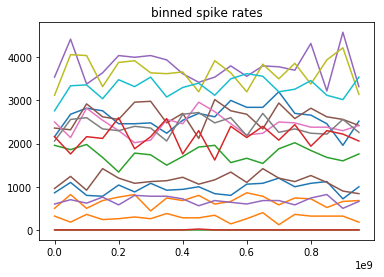

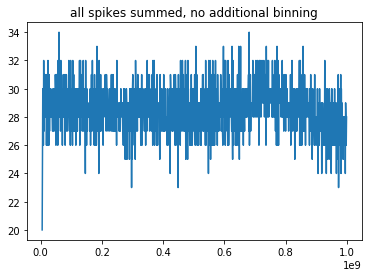

In [69]:
def spike_bins_to_rates(spikes, orig_bin_times, desired_bin_times):
    rates = np.zeros((len(desired_bin_times) - 1, spikes.shape[1]))
    for inp_idx, time in enumerate(desired_bin_times[:-1]):
        # XXX this is kind of overkill, should be able to infer indices
        valid_start_time = time 
        valid_end_time   = desired_bin_times[inp_idx + 1]
        start_bin_idx = np.searchsorted(orig_bin_times, valid_start_time)
        end_bin_idx = np.searchsorted(orig_bin_times, valid_end_time)
        summed_spikes = np.sum(spikes[start_bin_idx:end_bin_idx], axis=0)
        rates[inp_idx] = summed_spikes / ((valid_end_time - valid_start_time) / 1e9)
    return rates

BINS_PER_S = 20
num_bins = int(RUN_TIME * BINS_PER_S)
desired_bins = np.linspace(0, RUN_TIME, num_bins+1) * 1e9

spike_rates = spike_bins_to_rates(spikes[pool], spike_bin_times, desired_bins)

print(desired_bins.shape)
print(spike_rates.shape)
print(np.sum(spike_rates))

plt.figure()
plt.plot(desired_bins[:-1], spike_rates)
plt.title('binned spike rates')

plt.figure()
plt.plot(spike_bin_times, np.sum(spikes[pool], axis=1))
plt.title('all spikes summed, no additional binning')



In [72]:
# now try collecting identity trick spikes

identity_dec = np.eye(N)
trick_net = net_builder.create_single_pool_net(Y, X, tap_matrix, biases=BIAS, decoders=identity_dec)
trick_inp = trick_net.get_inputs()[0]
trick_outp = trick_net.get_outputs()[0]

run = RunControl(HAL, trick_net)

HAL.map(trick_net)

times = np.array([0, 1]) * 1e9
zero_rates = np.zeros((len(times), pool.dimensions))                                              
input_vals = {trick_inp: (times, zero_rates)}
trick_spikes_and_bin_times, _ = run.run_input_sweep(input_vals, get_raw_spikes=False, get_outputs=True)
trick_spikes, trick_spike_bin_times = trick_spikes_and_bin_times

Text(0.5,1,'all spikes summed and binned')

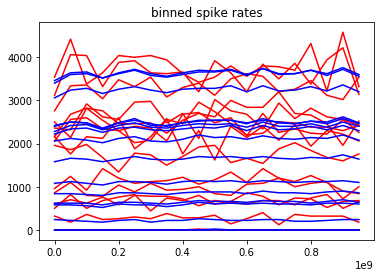

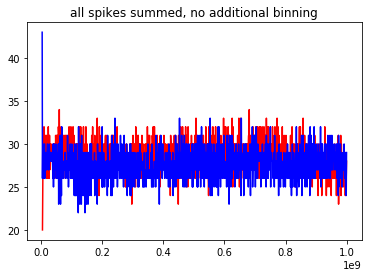

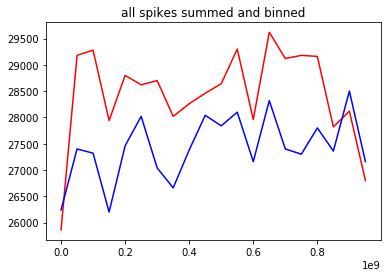

In [86]:
trick_spike_rates = spike_bins_to_rates(trick_spikes[trick_outp], trick_spike_bin_times, desired_bins)

plt.figure()
plt.plot(desired_bins[:-1], spike_rates, 'r')
plt.plot(desired_bins[:-1], trick_spike_rates, 'b')
plt.title('binned spike rates')

plt.figure()
plt.plot(spike_bin_times, np.sum(spikes[pool], axis=1), 'r')
plt.plot(trick_spike_bin_times, np.sum(trick_spikes[trick_outp], axis=1), 'b')
plt.title('all spikes summed, no additional binning')

def sum_and_make_plot(spikes, spike_bin_times, desired_bins, col):
    sum_spikes = np.sum(spikes, axis=1)
    sum_spikes = sum_spikes.reshape(len(sum_spikes), 1)
    sum_rates = spike_bins_to_rates(sum_spikes, spike_bin_times, desired_bins)
    plt.plot(desired_bins[:-1], sum_rates, col)
    
plt.figure()
sum_and_make_plot(spikes[pool], spike_bin_times, desired_bins, 'r')
sum_and_make_plot(trick_spikes[trick_outp], trick_spike_bin_times, desired_bins, 'b')
plt.title('all spikes summed and binned')